Bachelor thesis - Richard Borschke - 7337876 - University of Cologne - A spatio-temporal analysis of usage patterns in free-floating shared mobility


# Data Preparation

This notebook contains the preprocessing of data, needed for analysis. Following steps are performed:
* Data loading of all provided trip files
* Data splitting into car, bicycle and scooter set
* Data cleaning of unusable trips and variables
* Data preparing of variables


time (18.11 to 29.2  +  05.11.) --> 5.11. excluded

data set misses 2 days (16. and 15. 01.)

car misses 4 days (06. to 09.12.)

### Imports

In [1]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns

### Methods

In [2]:
# load full data (all modes) based on selected months
def load_data(months):
    first_read = True
    for month in months:
        data_month = pd.concat([pd.read_csv(file) for file in glob.glob('Data/Trip_{}/*_trip.csv'.format(month))], 
                               ignore_index = True)
        if (first_read):
            data_full = data_month
            first_read = False
        else:
            data_full = pd.concat([data_full, data_month], ignore_index=True)
    return data_full

# calculate speed (approx.) in kmph
def calculate_speed(data_full):
    data_full['speed'] = (data_full['distance'] / data_full['duration']) * 3.6
    return data_full

# split data into modes
def split_data(mode, data_full):
    data_mode = data_full.loc[data_full['vehicleType'] == mode].copy()
    return data_mode   
    
# values to clean data
def get_values_to_clean_data(mode):
    values = {}
    # 388972800s equals 1 day
    if (mode == 'car'):
        values = {'duration_high': 388972800, 'duration_low': 60, 'distance_high': 35000, 'distance_low': 100, 
                  'speed_high': 130, 'speed_low': 0}
    if (mode == 'bicycle'):
        values = {'duration_high': 388972800, 'duration_low': 60, 'distance_high': 35000, 'distance_low': 100, 
                  'speed_high': 25, 'speed_low': 0}
    if (mode == 'scooter'):
        values = {'duration_high': 388972800, 'duration_low': 60, 'distance_high': 35000, 'distance_low': 100, 
                  'speed_high': 25, 'speed_low': 0}
    return values

# clean data based on mode and selected variables
def clean_data(mode, data_mode):
    # get values of mode
    values = get_values_to_clean_data(mode)
    # clean provider data with low observation time (drivenow, lime and bird)
    # and delete conditions based on values
    delete_conditions = [(data_mode['provider'] == 'drivenow') | (data_mode['provider'] == 'lime') | 
                         (data_mode['provider'] == 'bird') | (data_mode['fuel_end']>data_mode['fuel_start']) | 
                         ((data_mode['distance']<values['distance_low'])|(data_mode['distance']>values['distance_high'])) |
                         ((data_mode['duration']<values['duration_low'])|(data_mode['duration']>values['duration_high'])) |
                         ((data_mode['speed']<values['speed_low'])|(data_mode['speed']>values['speed_high']))]
    # clean data based on conditions
    trips_to_delete = data_mode[delete_conditions[0]].index
    data_mode.drop(trips_to_delete , inplace=True)
    return data_mode

# prepare data
def prepare_data(data_mode):
    # drop unneeded variables
    data_mode.drop(['city', 'model', 'datetime_start', 'datetime_end', 'fuel_start', 'fuel_end', 
                    'price_driving_start', 'price_driving_end', 'price_promo_start', 'price_promo_end',
                    'missing_file_number'], axis = 1, inplace = True)
    # calculate start and end coordinates, round due to GPS accuracy
    data_mode["coordinates_start"] = list(zip(data_mode["latitude_start"].round(4), data_mode["longitude_start"].round(4)))
    data_mode["coordinates_end"] = list(zip(data_mode["latitude_end"].round(4), data_mode["longitude_end"].round(4)))
    # convert date
    data_mode['date_start'] = pd.to_datetime(data_mode['date_start'], format='%Y%m%d')
    data_mode['date_end'] = pd.to_datetime(data_mode['date_end'], format='%Y%m%d')
    # create columns year, month (1-12), weekday (0-6), hour (0-23) and weekend (binary identifier) based on date_start
    data_mode['year'] = data_mode['date_start'].apply(lambda x: x.year)
    data_mode['month'] = data_mode['date_start'].apply(lambda x: x.month)
    data_mode["weekday"] = data_mode["date_start"].apply(lambda x: x.weekday())
    data_mode["hour"] = (data_mode["time_start"] / 100).apply(np.floor).astype('int32')
    data_mode['weekend'] = np.where(data_mode['weekday'] > 4, 1, 0)
    # string switch: kick scooter into scooter (easier referencing)
    data_mode['vehicleType'] = np.where(data_mode['vehicleType'] == 'kick scooter', 'scooter', data_mode['vehicleType'])
    # arange order of columns
    data_mode = data_mode[['id', 'provider', 'vehicleType',  
                           'date_start', 'time_start', 'date_end', 'time_end', 
                           'year', 'month', 'weekday', 'hour', 'weekend', 
                           'longitude_start', 'latitude_start', 'longitude_end', 'latitude_end', 
                           'coordinates_start', 'coordinates_end', 
                           'distance', 'duration', 'speed']]
    # sort rows by date_start, time_start, time_end and id
    data_mode.sort_values(by = ['date_start', 'time_start', 'time_end', 'id'], ascending = True, inplace = True)
    # reset index
    data_mode = data_mode.reset_index(drop=True)
    return data_mode

# save data by mode and months
def save_prepared_data(months, data_prepared):
    for month in months:
        # extract month, year and mode
        only_month = int(month[4:])
        only_year = int(month[:4])
        mode_name_file = data_prepared['vehicleType'].iloc[0]
        # create dataframe and save it as csv file
        split_cond = [(data_prepared['month'] == only_month) & (data_prepared['year'] == only_year)]
        data_prepared[split_cond[0]].to_csv('Data/Modes/data_prepared_{}_{}.csv'.format(mode_name_file, month), index = False)

# save data by mode only
def save_prepared_data_full(data_prepared):
    mode_name_file = data_prepared['vehicleType'].iloc[0]
    # create dataframe and save it as csv file
    data_prepared.to_csv('Data/Modes/data_prepared_full_{}.csv'.format(mode_name_file), index = False)

### Execution

In [3]:
# define months for preparation (YYYYMM) - WARNING: too many months take a lot of RAM
months = ['201911', '201912', '202001', '202002']

In [4]:
# read in desired data by selected months and calculate speed to prepare for cleaning
data_full = calculate_speed(load_data(months))
len(data_full)

1037703

In [5]:
len(data_full[data_full['provider']=='driveby'])

12284

In [6]:
# check for unobserved days of providers (maybe logging failed in the data mining process)
observed_days_of_provider = {'car2go': len(data_full[data_full['provider']=='car2go']['date_start'].unique()), 
                             'drivenow': len(data_full[data_full['provider']=='drivenow']['date_start'].unique()),
                             'driveby': len(data_full[data_full['provider']=='driveby']['date_start'].unique()),
                             'kvb': len(data_full[data_full['provider']=='kvb']['date_start'].unique()),
                             'fordpass': len(data_full[data_full['provider']=='fordpass']['date_start'].unique()),
                             'lime': len(data_full[data_full['provider']=='lime']['date_start'].unique()),
                             'bird': len(data_full[data_full['provider']=='bird']['date_start'].unique()),
                             'circ': len(data_full[data_full['provider']=='circ']['date_start'].unique()),
                             'tier': len(data_full[data_full['provider']=='tier']['date_start'].unique())}
observed_days_of_provider

{'car2go': 98,
 'drivenow': 53,
 'driveby': 98,
 'kvb': 101,
 'fordpass': 102,
 'lime': 29,
 'bird': 11,
 'circ': 97,
 'tier': 102}

#### `Free-floating car data`

In [7]:
# car
# split data to select desired mode
data_car = split_data('car', data_full)
# clean mode data
data_car = clean_data('car', data_car)
# prepare mode data
data_car = prepare_data(data_car)

In [8]:
data_car['provider'].unique()

array(['car2go', 'driveby'], dtype=object)

In [9]:
len(data_car[data_car['provider']=='driveby'])

11505

#### `Free-floating bicycle data`

In [10]:
# bicycle
# split data to select desired mode
data_bicycle = split_data('bicycle', data_full)
# clean mode data
data_bicycle = clean_data('bicycle', data_bicycle)
# prepare mode data
data_bicycle = prepare_data(data_bicycle)

In [11]:
data_bicycle.head()

,id,provider,vehicleType,date_start,time_start,date_end,time_end,year,month,weekday,...,weekend,longitude_start,latitude_start,longitude_end,latitude_end,coordinates_start,coordinates_end,distance,duration,speed
0,YmlrZTo6Zm9yZHBhc3M6OjE4MzMzOA==,fordpass,bicycle,2019-11-18,1335,2019-11-19,1245,2019,11,0,...,0,6.921938,50.950490,6.921433,50.947918,"(50.9505, 6.9219)","(50.9479, 6.9214)",288.165776,83379.0,0.012442
1,YmlrZTo6Zm9yZHBhc3M6OjE4NjcwNg==,fordpass,bicycle,2019-11-18,1335,2019-11-18,1350,2019,11,0,...,0,6.973842,50.936730,6.990880,50.936005,"(50.9367, 6.9738)","(50.936, 6.9909)",1196.591890,880.0,4.895149
2,YmlrZTo6Zm9yZHBhc3M6OjE4MDUwOA==,fordpass,bicycle,2019-11-18,1345,2019-11-19,225,2019,11,0,...,0,6.956142,50.936860,6.943732,50.937824,"(50.9369, 6.9561)","(50.9378, 6.9437)",876.151797,45596.0,0.069176
3,YmlrZTo6Zm9yZHBhc3M6OjE3OTg1Mw==,fordpass,bicycle,2019-11-18,1350,2019-11-18,1410,2019,11,0,...,0,6.932356,50.949078,6.937432,50.938644,"(50.9491, 6.9324)","(50.9386, 6.9374)",1213.497791,1200.0,3.640493
4,YmlrZTo6Zm9yZHBhc3M6OjE3OTcxMA==,fordpass,bicycle,2019-11-18,1355,2019-11-19,1745,2019,11,0,...,0,6.955943,50.943134,6.993549,50.948940,"(50.9431, 6.9559)","(50.9489, 6.9935)",2712.573882,100203.0,0.097455


#### `Free-floating scooter data`

In [12]:
# kick scooter
# split data to select desired mode
data_scooter = split_data('kick scooter', data_full)
# clean mode data
data_scooter = clean_data('scooter', data_scooter)
# prepare mode data
data_scooter = prepare_data(data_scooter)

In [13]:
data_scooter.head()
data_scooter['provider'].unique()

array(['tier', 'circ'], dtype=object)

### Save data sets

In [14]:
# save prepared data sets based on selected months
# split data by month to avoid file size > 100 MB due to GitHub rules
# set True if saving is desired
save_data = False
if (save_data):
    save_prepared_data(months, data_car)
    save_prepared_data(months, data_bicycle)
    save_prepared_data(months, data_scooter)

In [15]:
# save prepared data sets in one file per mode
# set True if saving is desired
save_data_full = False
if (save_data_full):
    save_prepared_data_full(data_car)
    save_prepared_data_full(data_bicycle)
    save_prepared_data_full(data_scooter)

### Test

In [16]:
data_bicycle.isnull().values.any()

False

In [17]:
len(data_car[(data_car['weekday'] == 0) & (data_car['hour'] == 2)])

248

In [18]:
type(data_full["time_start"])

pandas.core.series.Series

In [19]:
data_car['provider'].unique()

array(['car2go', 'driveby'], dtype=object)

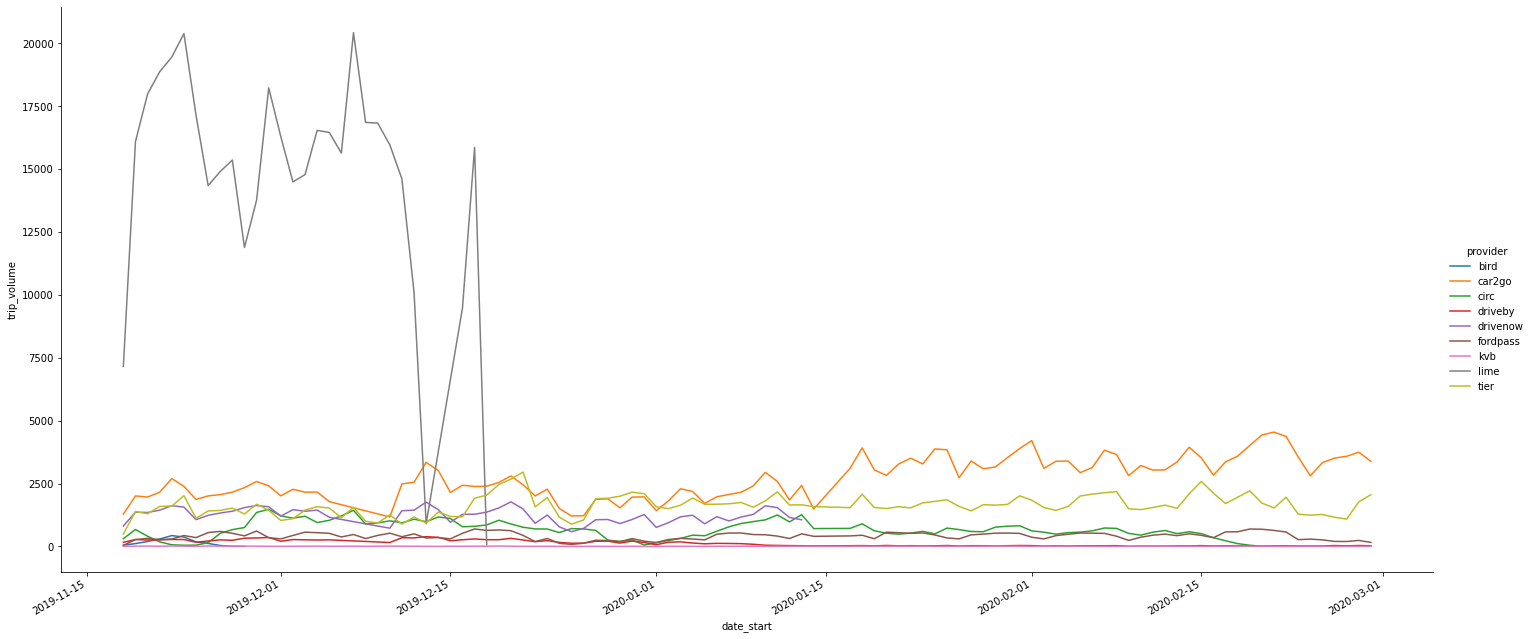

In [20]:
data_full['date_start'] = pd.to_datetime(data_full['date_start'], format='%Y%m%d')
#dataF = pd.concat([data_car, data_bicycle, data_scooter])
df = data_full.groupby(['date_start', 'provider']).count()
df['trip_volume'] = df['id']
df = df[['trip_volume','vehicleType']]

#df = df.sort_values(['date_start', 'month'])
df = df.sort_values(['date_start', 'provider'])

g = sns.relplot(x="date_start", y="trip_volume", kind="line", data=df, hue="provider", height=10, aspect=2)
g.fig.autofmt_xdate()
#data_full[data_full['provider']=='kvb'].describe()

In [22]:
len(data_bicycle['hour']==6)

39720